In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# Parameters
# -----------------------------
RFD_0 = 15000  # N/s, baseline peak rate of force development
durations = np.array([0, 2, 5, 10, 20, 30, 60])
max_duration = 60  # for linear model

In [3]:
# -----------------------------
# Linear model
# -----------------------------
A_linear = durations / max_duration
RFD_linear = RFD_0 * (1 - 0.7 * A_linear)

In [4]:
# -----------------------------
# Nonlinear model
# -----------------------------
def nonlinear_mapping_rfd(d):
    return 1 - (1 - np.exp(-0.25 * (d - 2).clip(min=0)))

RFD_nonlinear = RFD_0 * nonlinear_mapping_rfd(durations)

In [5]:
# -----------------------------
# Percentage loss
# -----------------------------
loss_RFD_linear = 100 * (1 - RFD_linear / RFD_0)
loss_RFD_nonlinear = 100 * (1 - RFD_nonlinear / RFD_0)

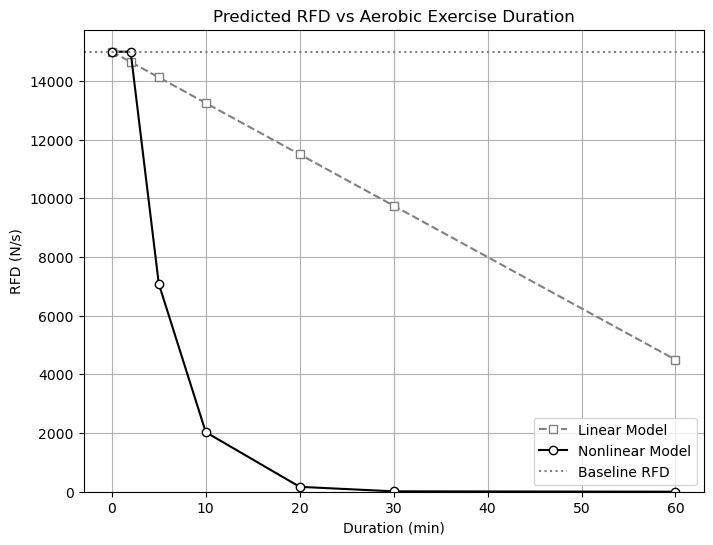

In [6]:
# -----------------------------
# Plot 1: Absolute RFD
# -----------------------------
plt.figure(figsize=(8,6))
plt.plot(durations, RFD_linear, color='gray', linestyle='--', marker='s', markerfacecolor='white', label="Linear Model")
plt.plot(durations, RFD_nonlinear, color='black', linestyle='-', marker='o', markerfacecolor='white', label="Nonlinear Model")
plt.axhline(RFD_0, color='gray', linestyle=':', label="Baseline RFD")
plt.ylim(0, RFD_0 * 1.05)
plt.title("Predicted RFD vs Aerobic Exercise Duration")
plt.xlabel("Duration (min)")
plt.ylabel("RFD (N/s)")
plt.grid(True)
plt.legend()

# Save as PNG
plt.savefig("RFD_absolute_linear_vs_nonlinear.png", dpi=300)

plt.show()

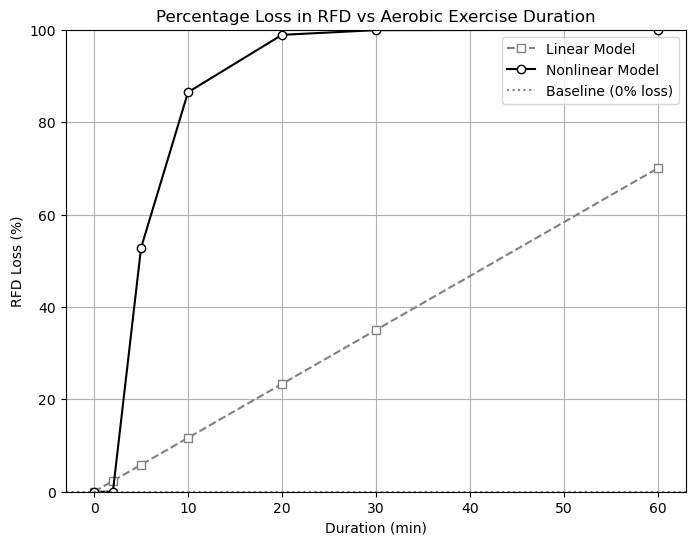

In [7]:
# -----------------------------
# Plot 2: % Loss of RFD
# -----------------------------
plt.figure(figsize=(8,6))
plt.plot(durations, loss_RFD_linear, color='gray', linestyle='--', marker='s', markerfacecolor='white', label="Linear Model")
plt.plot(durations, loss_RFD_nonlinear, color='black', linestyle='-', marker='o', markerfacecolor='white', label="Nonlinear Model")
plt.axhline(0, color='gray', linestyle=':', label="Baseline (0% loss)")
plt.ylim(0, 100)
plt.title("Percentage Loss in RFD vs Aerobic Exercise Duration")
plt.xlabel("Duration (min)")
plt.ylabel("RFD Loss (%)")
plt.grid(True)
plt.legend()

# Save as PNG
plt.savefig("RFD_loss_linear_vs_nonlinear.png", dpi=300)

plt.show()

In [8]:
# -------------------------------
# Nonlinear predictive equation for RFD
# -------------------------------
def predict_rfd(RFD0, d, g=0.50, lam=0.10, b=0.20, mu=0.06):
    """
    Predict RFD after d minutes of aerobic exercise (nonlinear model).
    """
    # RFD channel interference (starts after 5 min)
    Ak = 0.0 if d <= 5 else 1 - math.exp(-lam * (d - 5))
    
    # Fmax channel interference (starts after 20 min)
    AF = 0.0 if d <= 20 else 1 - math.exp(-mu * (d - 20))
    
    return RFD0 * (1 - g * Ak) * (1 - b * AF)

# -------------------------------
# Linear model for comparison
# -------------------------------
def predict_rfd_linear(RFD0, d, max_drop=0.5, max_dur=60):
    """
    Simple linear decline in RFD:
    0 min -> 100% RFD
    max_dur min -> (1 - max_drop) * RFD0
    """
    frac_loss = min(max_drop * d / max_dur, max_drop)
    return RFD0 * (1 - frac_loss)

# -------------------------------
# Example usage
# -------------------------------
RFD0 = 8000  # baseline RFD (N/s), set per athlete
durations = [0, 5, 7, 10, 15, 20, 30, 45, 60]

results = []
for d in durations:
    pred_nonlin = predict_rfd(RFD0, d)
    pred_lin = predict_rfd_linear(RFD0, d)
    drop_nonlin = 100 * (1 - pred_nonlin / RFD0)
    drop_lin = 100 * (1 - pred_lin / RFD0)
    results.append({
        "Duration (min)": d,
        "Nonlinear Predicted RFD": round(pred_nonlin, 1),
        "Nonlinear Drop (%)": round(drop_nonlin, 1),
        "Linear Predicted RFD": round(pred_lin, 1),
        "Linear Drop (%)": round(drop_lin, 1)
    })

df = pd.DataFrame(results)
display(df)

,Duration (min),Nonlinear Predicted RFD,Nonlinear Drop (%),Linear Predicted RFD,Linear Drop (%)
0,0,8000.0,0.0,8000.0,0.0
1,5,8000.0,0.0,7666.7,4.2
2,7,7274.9,9.1,7533.3,5.8
3,10,6426.1,19.7,7333.3,8.3
4,15,5471.5,31.6,7000.0,12.5
5,20,4892.5,38.8,6666.7,16.7
6,30,3937.8,50.8,6000.0,25.0
7,45,3440.4,57.0,5000.0,37.5
8,60,3285.9,58.9,4000.0,50.0


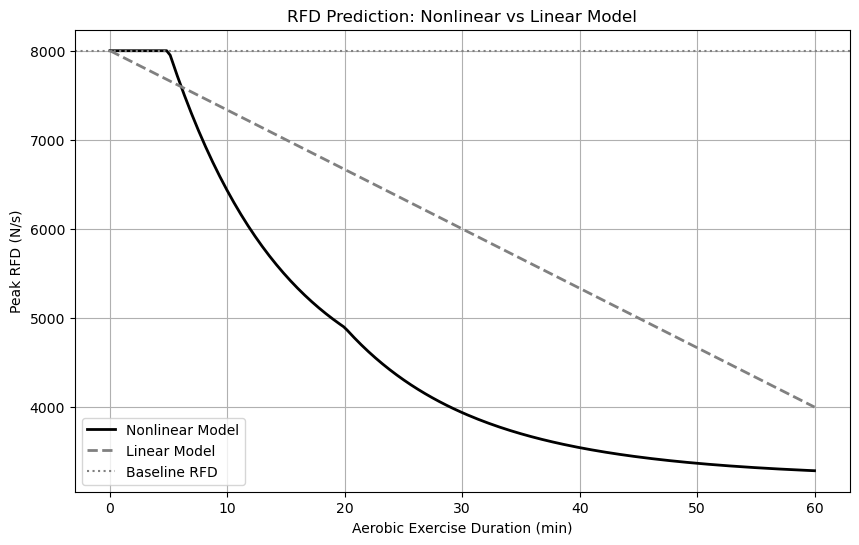

In [9]:
# -------------------------------
# Plot comparison
# -------------------------------
dur_range = np.linspace(0, 60, 200)
preds_nonlin = [predict_rfd(RFD0, d) for d in dur_range]
preds_lin = [predict_rfd_linear(RFD0, d) for d in dur_range]

plt.figure(figsize=(10,6))
plt.plot(dur_range, preds_nonlin, color='black', linestyle='-', label="Nonlinear Model", linewidth=2)
plt.plot(dur_range, preds_lin, color='gray', linestyle='--', label="Linear Model", linewidth=2)
plt.axhline(RFD0, color="gray", linestyle=":", label="Baseline RFD")
plt.xlabel("Aerobic Exercise Duration (min)")
plt.ylabel("Peak RFD (N/s)")
plt.title("RFD Prediction: Nonlinear vs Linear Model")
plt.legend()
plt.grid(True)
plt.show()

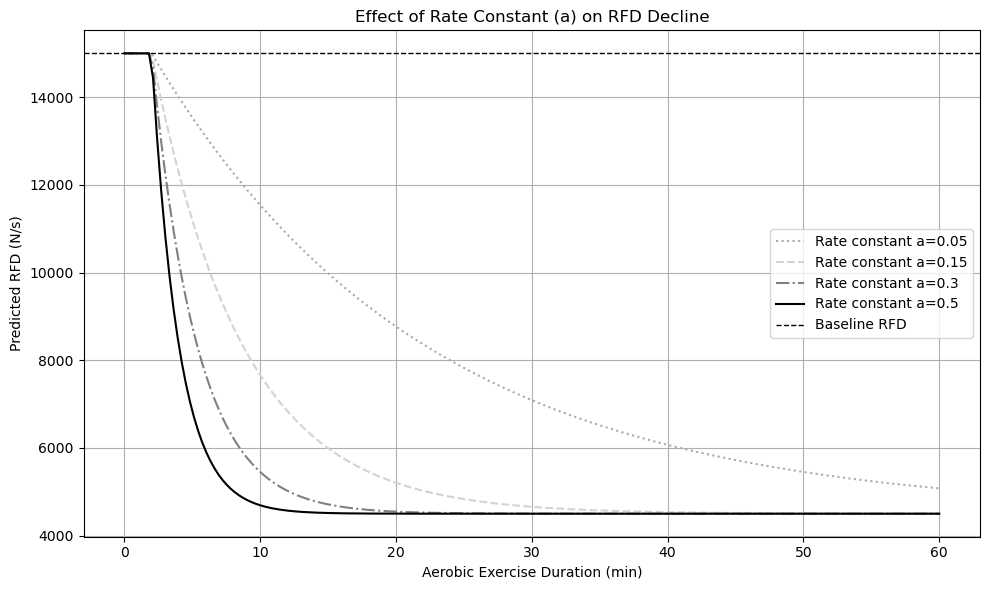

In [10]:
# -----------------------------
# Nonlinear model for RFD
# -----------------------------
def nonlinear_rfd(duration, RFD_0, k_RFD=0.7, a=0.25, d0=2):
    duration = np.array(duration)
    scaling = 1 - k_RFD * (1 - np.exp(-a * np.maximum(0, duration - d0)))
    return RFD_0 * scaling

# -----------------------------
# Parameters
# -----------------------------
RFD_0 = 15000   # baseline RFD (N/s)
durations = np.linspace(0, 60, 200)

# Different rate constants for comparison
a_values = [0.05, 0.15, 0.3, 0.5]  # very gradual → very steep
colors = ['darkgray', 'lightgray', 'gray', 'black']
linestyles = [':', '--', '-.', '-']

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 6))

for a, c, l in zip(a_values, colors, linestyles):
    RFD_curve = nonlinear_rfd(durations, RFD_0, k_RFD=0.7, a=a, d0=2)
    plt.plot(durations, RFD_curve, color=c, linestyle=l, label=f"Rate constant a={a}")

# Baseline line (no exercise)
plt.axhline(RFD_0, color='k', linestyle='--', linewidth=1, label="Baseline RFD")

plt.title("Effect of Rate Constant (a) on RFD Decline")
plt.xlabel("Aerobic Exercise Duration (min)")
plt.ylabel("Predicted RFD (N/s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Rate_Constant.png", dpi=300)
plt.show()

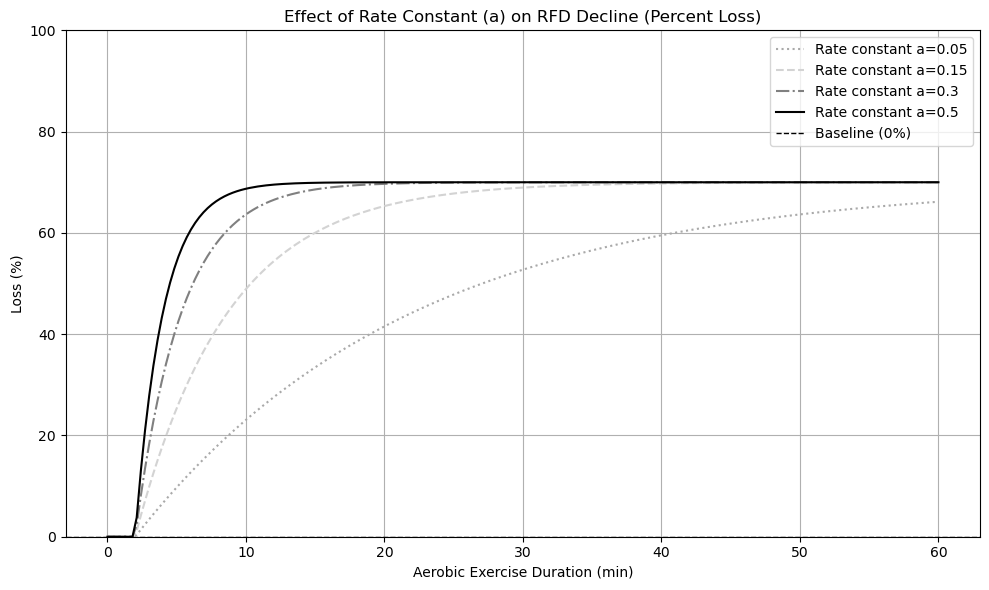

In [11]:
# -----------------------------
# Plot Percent Loss
# -----------------------------
plt.figure(figsize=(10, 6))

for a, c, l in zip(a_values, colors, linestyles):
    RFD_curve = nonlinear_rfd(durations, RFD_0, k_RFD=0.7, a=a, d0=2)
    percent_change = (RFD_curve - RFD_0) / RFD_0 * -100
    plt.plot(durations, percent_change, color=c, linestyle=l, label=f"Rate constant a={a}")

# Baseline (0% change)
plt.axhline(0, color='k', linestyle='--', linewidth=1, label="Baseline (0%)")

plt.title("Effect of Rate Constant (a) on RFD Decline (Percent Loss)")
plt.xlabel("Aerobic Exercise Duration (min)")
plt.ylabel("Loss (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Rate_Constant_PercentChange.png", dpi=300)
plt.show()

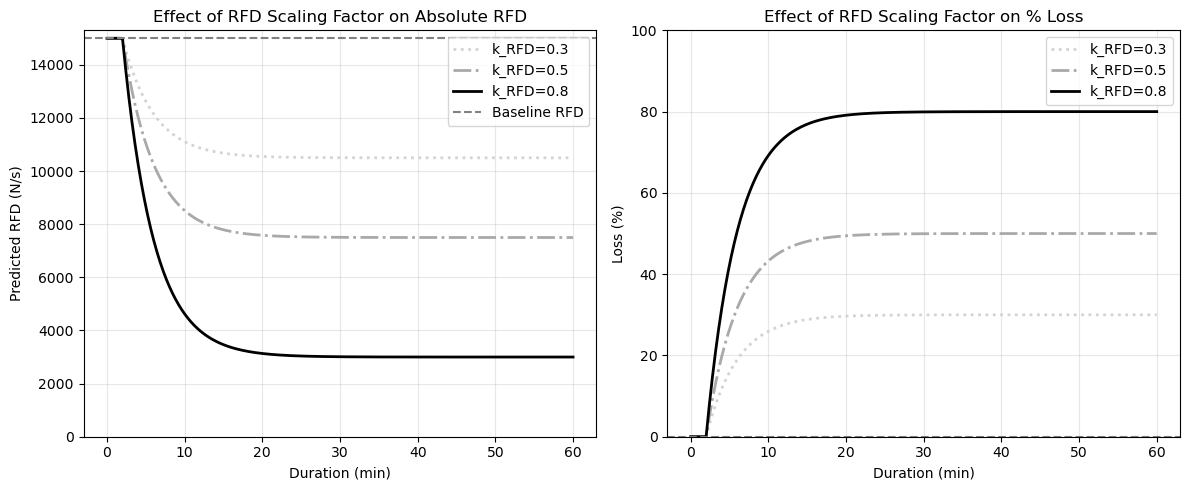

In [12]:
# -----------------------------
# Parameters
# -----------------------------
RFD_0 = 15000.0   # Baseline peak RFD (N/s)
a = 0.25          # Rate constant
d0 = 2.0          # Onset time (min)
durations = np.linspace(0, 60, 300)  # Aerobic durations from 0–60 min

# Scaling factors to compare
k_values = [0.3, 0.5, 0.8]
colors = ['lightgray', 'darkgray', 'black']
linestyles = [':', '-.', '-']

# -----------------------------
# Create plots
# -----------------------------
plt.figure(figsize=(12,5))

# --- Absolute RFD subplot ---
plt.subplot(1,2,1)
for k, c, l in zip(k_values, colors, linestyles):
    RFD_curve = RFD_0 * (1 - k * (1 - np.exp(-a * np.clip(durations - d0, 0, None))))
    plt.plot(durations, RFD_curve, color=c, linestyle=l, lw=2, label=f"k_RFD={k}")
plt.axhline(RFD_0, color='gray', ls='--', label='Baseline RFD')
plt.title('Effect of RFD Scaling Factor on Absolute RFD')
plt.xlabel('Duration (min)')
plt.ylabel('Predicted RFD (N/s)')
plt.ylim(0, RFD_0*1.02)
plt.grid(alpha=0.3)
plt.legend()

# --- Percent loss subplot ---
plt.subplot(1,2,2)
for k, c, l in zip(k_values, colors, linestyles):
    RFD_curve = RFD_0 * (1 - k * (1 - np.exp(-a * np.clip(durations - d0, 0, None))))
    loss_pct = 100 * (1 - RFD_curve / RFD_0)
    plt.plot(durations, loss_pct, color=c, linestyle=l, lw=2, label=f"k_RFD={k}")
plt.axhline(0, color='gray', ls='--')
plt.title('Effect of RFD Scaling Factor on % Loss')
plt.xlabel('Duration (min)')
plt.ylabel('Loss (%)')
plt.ylim(0, 100)
plt.grid(alpha=0.3)
plt.legend()

# -----------------------------
# Save figure as PNG
# -----------------------------
plt.tight_layout()
plt.savefig("rfd_scaling_factor_comparison.png", dpi=300)
plt.show()

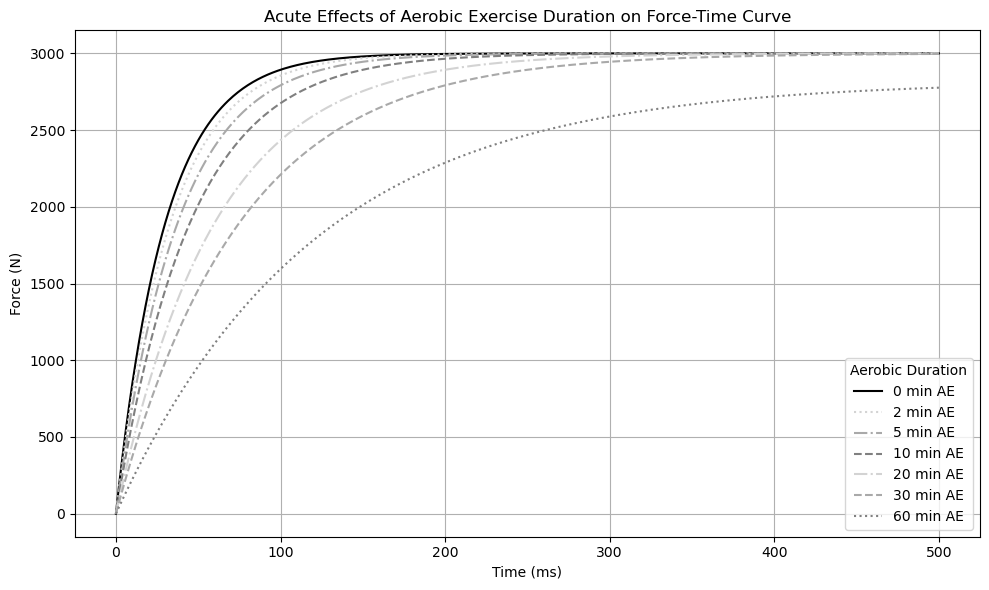

In [13]:
# Baseline parameters
F_max_base = 3000       # Peak force in Newtons
tau_0 = 0.03            # Baseline time constant (seconds) = 30 ms

# Aerobic durations in minutes
durations = [0, 2, 5, 10, 20, 30, 60]

# Plotting parameters
colors = ['black', 'lightgray', 'darkgray', 'gray', 'lightgray', 'darkgray', 'gray']
linestyles = ['-', ':', '-.', '--', '-.', '--', ':']

# Parameters for shift and force reduction
shift_per_min = 0.0015    # Increase in tau per minute (s)
force_drop_threshold = 30 # Minutes after which max force drops
force_drop_per_min = 0.002  # Fractional drop per minute beyond threshold

# Time vector (0 to 0.5 seconds)
time = np.linspace(0, 0.5, 500)

def force_time_curve(F_max, tau, t):
    # Force rises exponentially towards F_max
    return F_max * (1 - np.exp(-t / tau))

plt.figure(figsize=(10, 6))

for dur, c, l in zip(durations, colors, linestyles):
    # Calculate shifted time constant
    tau = tau_0 + shift_per_min * dur

    # Calculate max force drop if applicable
    if dur > force_drop_threshold:
        excess = dur - force_drop_threshold
        F_max = F_max_base * (1 - force_drop_per_min * excess)
    else:
        F_max = F_max_base

    # Generate force-time data
    force = force_time_curve(F_max, tau, time)

    # Plotting (convert time to ms)
    plt.plot(time * 1000, force, color=c, linestyle=l, label=f'{dur} min AE')

plt.title('Acute Effects of Aerobic Exercise Duration on Force-Time Curve')
plt.xlabel('Time (ms)')
plt.ylabel('Force (N)')
plt.legend(title='Aerobic Duration')
plt.grid(True)
plt.tight_layout()
plt.savefig("Acute_Effects.png", dpi=300)
plt.show()

In [14]:
# -----------------------------
# Nonlinear RFD prediction function
# -----------------------------
def nonlinear_rfd(duration, RFD_0, k_RFD=0.7, a=0.25, d0=2):
    """
    Predicts RFD after aerobic exercise.

    Parameters:
    ----------
    duration : float or array
        Aerobic exercise duration in minutes
    RFD_0 : float
        Baseline peak RFD (N/s)
    k_RFD : float
        Scaling factor (max fractional drop, 0–1)
    a : float
        Rate constant (steepness of drop)
    d0 : float
        Onset (minutes) when RFD starts to drop
    """
    duration = np.array(duration)  # allow both scalar and array
    scaling = 1 - k_RFD * (1 - np.exp(-a * np.clip(duration - d0, 0, None)))
    return RFD_0 * scaling

,Duration (min),Predicted RFD (N/s),Predicted % Loss
0,2,15000.00,0.00
1,5,9459.85,36.93
2,10,5921.02,60.53
3,20,4616.64,69.22
4,30,4509.57,69.94
5,60,4500.01,70.00


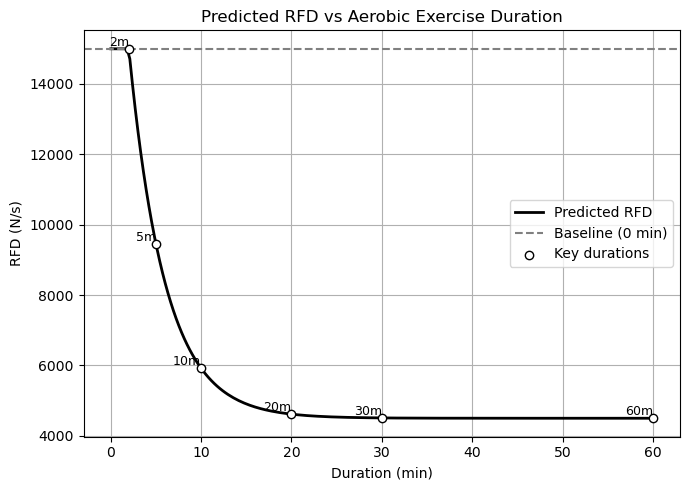

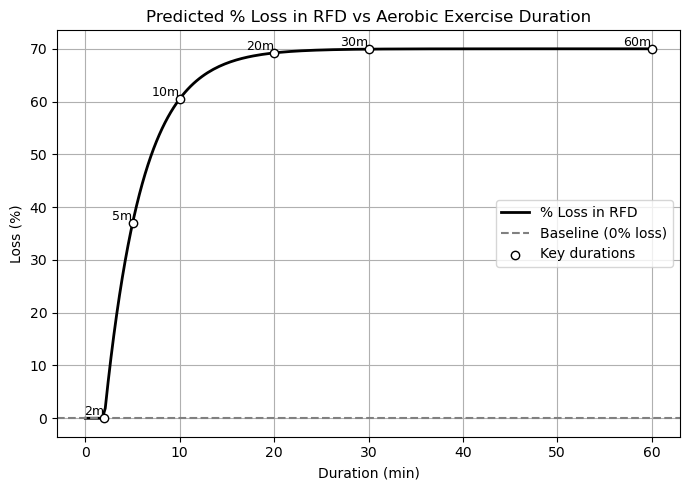

In [15]:
# -----------------------------
# Multiple durations to highlight
# -----------------------------
highlight_durations = [2, 5, 10, 20, 30, 60]

# Compute RFD values for smooth curve
durations = np.linspace(0, 60, 200)
RFD_values = nonlinear_rfd(durations, RFD_0)
loss_values = 100 * (1 - RFD_values / RFD_0)

# Compute points at highlight durations
RFD_points = nonlinear_rfd(highlight_durations,  RFD_0)
loss_points = 100 * (1 - RFD_points / RFD_0)

# -----------------------------
# Table of results
# -----------------------------
results_df = pd.DataFrame({
    "Duration (min)": highlight_durations,
    "Predicted RFD (N/s)": RFD_points.round(2),
    "Predicted % Loss": loss_points.round(2)
})

display(results_df)

# -----------------------------
# Figure 1: RFD vs duration
# -----------------------------
plt.figure(figsize=(7,5))
plt.plot(durations, RFD_values, color='black', linestyle='-', linewidth=2, label="Predicted RFD")
plt.axhline(RFD_0, color='gray', linestyle='--', label="Baseline (0 min)")
plt.scatter(highlight_durations, RFD_points, color='black', marker='o', facecolors='white', zorder=5, label="Key durations")
for d, r in zip(highlight_durations, RFD_points):
    plt.text(d, r, f"{d}m", ha='right', va='bottom', fontsize=9)
plt.title("Predicted RFD vs Aerobic Exercise Duration")
plt.xlabel("Duration (min)")
plt.ylabel("RFD (N/s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Predicted_RFD_curve.png", dpi=300)
plt.show()

# -----------------------------
# Figure 2: % Loss vs duration
# -----------------------------
plt.figure(figsize=(7,5))
plt.plot(durations, loss_values, color='black', linestyle='-', linewidth=2, label="% Loss in RFD")
plt.axhline(0, color='gray', linestyle='--', label="Baseline (0% loss)")
plt.scatter(highlight_durations, loss_points, color='black', marker='o', facecolors='white', zorder=5, label="Key durations")
for d, l in zip(highlight_durations, loss_points):
    plt.text(d, l, f"{d}m", ha='right', va='bottom', fontsize=9)
plt.title("Predicted % Loss in RFD vs Aerobic Exercise Duration")
plt.xlabel("Duration (min)")
plt.ylabel("Loss (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Predicted_RFD_loss_curve.png", dpi=300)
plt.show()

In [ ]:
# -----------------------------
# Nonlinear RFD prediction model
# -----------------------------
def predict_rfd(RFD_peak, duration, k_RFD=0.8, a=0.25, d0=2):
    """
    Predict RFD after aerobic exercise using exponential decay model.

    Parameters:
    - RFD_peak: baseline (peak) RFD value (N/s)
    - duration: aerobic exercise duration (min)
    - k_RFD: scaling factor (0–1), max proportional loss at long duration
    - a: rate constant (steepness of decay)
    - d0: onset time (min), when loss begins

    Returns:
    - predicted RFD value
    - % loss compared to baseline
    """
    # Exponential decay mapping
    scaling = k_RFD * (1 - np.exp(-a * (duration - d0))) if duration > d0 else 0
    RFD_pred = RFD_peak * (1 - scaling)

    loss_percent = 100 * (1 - RFD_pred / RFD_peak)
    return RFD_pred, loss_percent


# -----------------------------
# Interactive prompt for coach
# -----------------------------
def run_interactive():
    print("=== RFD Prediction Model ===")
    RFD_peak = float(input("Enter athlete's peak RFD (N/s): "))
    duration = float(input("Enter aerobic exercise duration (min): "))

    # Allow coach to adjust model parameters
    k_RFD = float(input("Enter scaling factor k_RFD (0–1, default=0.8): ") or 0.8)
    a = float(input("Enter rate constant a (default=0.25): ") or 0.25)
    d0 = float(input("Enter onset time d0 in minutes (default=2): ") or 2)

    RFD_pred, loss_percent = predict_rfd(RFD_peak, duration, k_RFD, a, d0)

    print("\n--- Prediction Results ---")
    print(f"Baseline Peak RFD: {RFD_peak:.1f} N/s")
    print(f"Duration of Aerobic Exercise: {duration:.1f} min")
    print(f"Predicted RFD after exercise: {RFD_pred:.1f} N/s")
    print(f"Predicted % Loss: {loss_percent:.1f}%")
    print("\n(Model parameters: k_RFD={k_RFD}, a={a}, d0={d0})")


# -----------------------------
# Run script
# -----------------------------
if __name__ == "__main__":
    run_interactive()